In [1]:
#package langue
import nltk
import re
from nltk.corpus import stopwords
import math

from string import punctuation
from collections import Counter

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

python twitter_streaming.py > twitter_data.txt

## Fonctions de traitement

### Texte

In [3]:
def lower(tweet):
    return tweet.lower()

In [4]:
def retrait_url(tweet):
    p = re.compile('http.*? ')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    p = re.compile('http(.)*')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    return tweet

In [5]:
def accents(tweet):
    a=['à','â']
    c=['ç']
    e=['é','è','ê','ë']
    i=['î','ï']
    o=['ô']
    u=['û','ù']
    for lettre in a:
        tweet=tweet.replace(lettre,'a')
    for lettre in c:
        tweet=tweet.replace(lettre,'c')
    for lettre in e:
        tweet=tweet.replace(lettre,'e')
    for lettre in i:
        tweet=tweet.replace(lettre,'i')
    for lettre in o:
        tweet=tweet.replace(lettre,'o')
    for lettre in u:
        tweet=tweet.replace(lettre,'u')
    return tweet

In [6]:
def retrait_chiffre(tweet):
    chiffres=['0','1','2','3','4','5','6','7','8','9']
    for i in chiffres:
        tweet=tweet.replace(i,'')
    return tweet

In [7]:
def separation_mots(tweet):
    tweet=tweet.replace('le pen','lepen')
    return tweet.split(' ')

In [8]:
def retrait_espace(tweet):
    tweet = [word for word in tweet if word !='']
    return tweet

In [9]:
def retrait_stopwords(tweet):
    stopwords = ['alors','au','aux','aucuns','aussi','autre','avant','avec','avoir','bon','ca','car','ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','debut','elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il','ils','je','la','le','les','leur','ma','maintenant','mais','mes','mine','moins','mon','mot','meme','ni','nommes','notre','nous','ou','par','parce','pas','peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si','sien','son','sont','sous','soyez','sur','ta','tandis','tellement','tels','tes','ton','tous','tout','trop','tres','tu','voient','vont','votre','vous','vu','etaient','etat','etions','ete','etre','rt']
    tweet = [word for word in tweet if word not in stopwords]
    return tweet

In [10]:
def retrait_ponctuation(tweet, punctuation_list):
    for p in punctuation_list:
        tweet=tweet.replace(p,' ')
    tweet=tweet.replace('…','')
    tweet=tweet.replace('\n','')
    return tweet

In [11]:
def process_text(row):
    processed_tweet = lower(row['text'])
    processed_tweet = retrait_url(processed_tweet)
    processed_tweet = accents(processed_tweet)
    processed_tweet = retrait_chiffre(processed_tweet)
    processed_tweet = retrait_ponctuation(processed_tweet, list(punctuation))
    processed_tweet = separation_mots(processed_tweet)
    processed_tweet = retrait_espace(processed_tweet)
    processed_tweet = retrait_stopwords(processed_tweet)
    return processed_tweet

### Ville

In [12]:
def ville(tweet):
    top_ville=['paris','marseille','lyon','toulouse','nice','nantes','strasbourg','montpellier','bordeaux','lille']
    result=' '
    for ville in top_ville:
        p = re.compile(ville)
        if p.search(tweet) :
            result=p.search(tweet).group()
    return result

### Source

In [13]:
def retrait_balise(tweet):
    p = re.compile('</a>')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    p = re.compile('<a(.)*>')
    if p.search(tweet) :
        result=p.search(tweet).group()
        tweet=tweet.replace(result,'')
    return tweet

### Candidats

---
- Francois FILLON
- Benoit HAMON
- Emmanuel MACRON
- Jean-Luc MELENCHON
- Jean LASSALLE
- Nicolas DUPONT-AIGNAN
- Nathalie ARTHAUD
- Marine LEPEN
- Francois ASSELINEAU
- Philippe POUTOU
- Jacques CHEMINADE
---

In [14]:
def presence_candidats(tweet,candidat):
    present=0
    for element in candidat:
        present=present + int(element in tweet)
    if present>=1:
        present=1
    return present

## Execution des fonctions

In [95]:
def process_tweet(file_name):
    tweets_data_path = '/Users/saramounir/'+file_name+'.txt'

    tweets_data = []
    tweets_file = open(tweets_data_path, "r")
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            if 'text' in tweet.keys() : 
                tweets_data.append(tweet)
        except:
            continue
    
    tweets = pd.DataFrame()
    
    tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
    tweets['date'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
    tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
    tweets['country'] = list(map(lambda tweet: tweet['user']['location'] if tweet['user']['location'] != None else None, tweets_data))
    tweets['user_name'] = list(map(lambda tweet: tweet['user']['name'] if tweet['user']['name'] != None else None, tweets_data))
    tweets['description_user'] = list(map(lambda tweet: tweet['user']['description'] if tweet['user']['description'] != None else None, tweets_data))
    tweets['source'] = list(map(lambda tweet: tweet['source'], tweets_data))
    
    tweets['nb_@']=tweets['text'].apply(lambda x : x.count('@'))
    tweets['nb_rt']=tweets['text'].apply(lambda x : x.count('RT'))
    tweets['text'] = tweets.apply(process_text, axis = 1)
    
    tweets['country']=tweets['country'].fillna(' ')
    tweets['country'] = tweets['country'].apply(lower)
    
    tweets['ville'] = tweets['country'].apply(ville)
    
    tweets['source'] = tweets['source'].apply(retrait_balise)
    
    asselineau=['asselineau','francoisasselineau']
    arthaud=['arthaud','nathaliearthaud']
    cheminade=['cheminade','jacquescheminade']
    dupontaignan=['dupontaignan','nicolasdupontaignan','nda']
    fillon=['fillon','fillongate','francoisfillon','tousfillon','jevotefillon']
    hamon=['benoithamon','jeunesavechamon','hamon']
    lassalle=['jeanlassalle','lassalle']
    lepen=['lepen','mlp','lafrancevotemarine','lepengate','marine','marinelepen','fn']
    macron=['macron','emmanuelmacron']
    melenchon=['jlmelenchon','melenchon','jlm','jeanlucmelenchon']
    poutou=['poutou','philippepoutou']
    
    tweets['asselineau'] = tweets['text'].apply(lambda line: presence_candidats(line,asselineau))
    tweets['arthaud'] = tweets['text'].apply(lambda line: presence_candidats(line,arthaud))
    tweets['cheminade'] = tweets['text'].apply(lambda line: presence_candidats(line,cheminade))
    tweets['dupontaignan'] = tweets['text'].apply(lambda line: presence_candidats(line,dupontaignan))
    tweets['fillon'] = tweets['text'].apply(lambda line: presence_candidats(line,fillon))
    tweets['hamon'] = tweets['text'].apply(lambda line: presence_candidats(line,hamon))
    tweets['lassalle'] = tweets['text'].apply(lambda line: presence_candidats(line,lassalle))
    tweets['lepen'] = tweets['text'].apply(lambda line: presence_candidats(line,lepen))
    tweets['macron'] = tweets['text'].apply(lambda line: presence_candidats(line,macron))
    tweets['melenchon'] = tweets['text'].apply(lambda line: presence_candidats(line,melenchon))
    tweets['poutou'] = tweets['text'].apply(lambda line: presence_candidats(line,poutou))
    
    tweets['nb_candidat']=tweets['asselineau']+tweets['arthaud']+tweets['cheminade']+tweets['dupontaignan']+tweets['fillon']+tweets['hamon']+tweets['lassalle']+tweets['lepen']+tweets['macron']+tweets['melenchon']+tweets['poutou']
    
    return tweets

In [96]:
tweets_mars=process_tweet('twitter_data')

In [97]:
tweets_avril=process_tweet('twitter_data_17avril')

#### Rajout label

In [98]:
tweet_label=pd.read_excel("/Users/saramounir/Desktop/tweets_23avril_après.xlsx")

In [99]:
label=tweet_label['label']
label
tweets_mars['label']=label

## Graphiques

### Network

In [36]:
network=pd.DataFrame()
for c in candidats:
    t=tweets_mars.loc[tweets_mars[c] == 1]
    t=t[['asselineau','arthaud','cheminade','dupontaignan','fillon','hamon','lassalle','lepen','macron','melenchon','poutou']]
    somme=t.sum()
    network[c]=somme
network

,asselineau,arthaud,cheminade,dupontaignan,fillon,hamon,lassalle,lepen,macron,melenchon,poutou
asselineau,53,0,0,4,2,0,4,2,4,0,5
arthaud,0,13,0,0,0,0,0,0,10,0,0
cheminade,0,0,2,0,0,0,0,0,0,0,0
dupontaignan,4,0,0,113,14,2,4,10,32,1,4
fillon,2,0,0,14,11161,38,1,93,167,342,1
hamon,0,0,0,2,38,419,0,31,92,52,1
lassalle,4,0,0,4,1,0,14,0,4,0,4
lepen,2,0,0,10,93,31,0,1170,110,59,3
macron,4,10,0,32,167,92,4,110,1801,76,66
melenchon,0,0,0,1,342,52,0,59,76,1031,1


{'arthaud': <matplotlib.text.Text at 0x11a32fbe0>,
 'asselineau': <matplotlib.text.Text at 0x11a321908>,
 'cheminade': <matplotlib.text.Text at 0x11a3160f0>,
 'dupontaignan': <matplotlib.text.Text at 0x11a3211d0>,
 'fillon': <matplotlib.text.Text at 0x11a327518>,
 'hamon': <matplotlib.text.Text at 0x11a32f0f0>,
 'lassalle': <matplotlib.text.Text at 0x11a3279e8>,
 'lepen': <matplotlib.text.Text at 0x11a31cac8>,
 'macron': <matplotlib.text.Text at 0x11a321f98>,
 'melenchon': <matplotlib.text.Text at 0x11a32f358>,
 'poutou': <matplotlib.text.Text at 0x11a3332b0>}

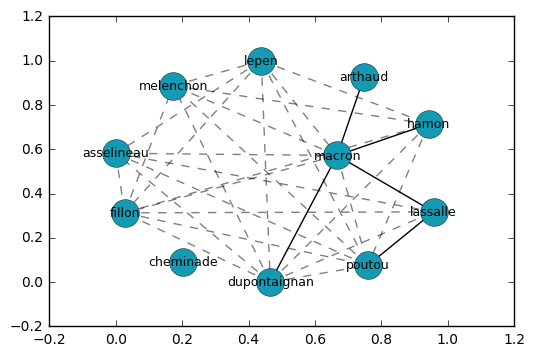

In [93]:
import networkx as nx

candidats=['asselineau','arthaud','cheminade','dupontaignan','fillon','hamon','lassalle','lepen','macron','melenchon','poutou']

G=nx.Graph()
G.add_nodes_from(candidats)

for i in range(0,11) :
    for j in range((i+1),11):
        c1=candidats[i]
        c2=candidats[j]
        w=network.iloc[i,j]/network.iloc[i].sum()
        
        if w>0:
            G.add_edge(c1,c2,weight=w)

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.1]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.1]

pos=nx.spring_layout(G) # positions for all nodes

nx.draw_networkx_nodes(G,pos,node_size=400,node_color='#139BB4',node_shape='o',linewidths=0.3)

nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=1)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,style='dashed')

nx.draw_networkx_labels(G,pos,font_size=9,font_family='sans-serif',font_weight='medium')

## Prédiction

In [102]:
from collections import Counter
X_train = list(tweets_mars.apply(lambda x:Counter(x['text']), axis = 1))
X_test = list(tweets_avril.apply(lambda x:Counter(x['text']), axis = 1))

In [103]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=True)
X_train = v.fit_transform(X_train)
X_train

<16414x14914 sparse matrix of type '<class 'numpy.float64'>'
	with 185563 stored elements in Compressed Sparse Row format>

In [104]:
X_test = v.transform(X_test)

In [105]:
from sklearn import cross_validation

train=tweets_mars.loc[tweets_mars['nb_candidat'] == 1]

print(train.shape)

train_target = tweets_mars.label
train_data = tweets_mars.drop(["label"], axis=1)

# Validation croisée
X = train_data
y = train_target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                        test_size=0.25, random_state=0)

print("%r, %r, %r" % (X.shape, X_train.shape, X_test.shape))

(13877, 23)
(16414, 22), (12310, 22), (4104, 22)


In [108]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train)

ValueError: could not convert string to float: 

In [ ]:
# use the model to predict the labels of the test data
y_pred = logistic.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_test_reglog, y_pred))

print(metrics.classification_report(y_test_reglog, y_pred))

## DF par mot

In [ ]:
final = pd.DataFrame(columns=['num_tweet','mot', 'nb_occurence'])
for line in tweets.itertuples():
    temp = [[line[0], x, y] for x, y in Counter(line[1]).items()]
    final = final.append(pd.DataFrame(temp,columns=['num_tweet','mot', 'nb_occurence']) , ignore_index = True)

In [ ]:
print(final.head(30))

In [ ]:
print('asselineau : ',sum(tweets['asselineau'])/len(tweets_data)*100)
print('arthaud : ',sum(tweets['arthaud'])/len(tweets_data)*100)
print('cheminade : ',sum(tweets['cheminade'])/len(tweets_data)*100)
print('dupontaignan : ',sum(tweets['dupontaignan'])/len(tweets_data)*100)
print('fillon : ',sum(tweets['fillon'])/len(tweets_data)*100)
print('hamon : ',sum(tweets['hamon'])/len(tweets_data)*100)
print('lassalle : ',sum(tweets['lassalle'])/len(tweets_data)*100)
print('lepen : ',sum(tweets['lepen'])/len(tweets_data)*100)
print('macron : ',sum(tweets['macron'])/len(tweets_data)*100)
print('melenchon : ',sum(tweets['melenchon'])/len(tweets_data)*100)
print('poutou : ',sum(tweets['poutou'])/len(tweets_data)*100)

In [ ]:

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [ ]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

In [ ]:
#tweets=tweets[0:500]
#tweets.to_csv("/Users/saramounir/Desktop/tweets_23avril_avant.csv",sep=';')
listei=[26,69,84,135,140,146,186,191,283,292,295,319,340,413,451,468,479,553,570,596,619,634,666,734,775,776,831,888,893,961,1011,1022,1033,1057,1092,1096,1149,1180,1207,1209,1219,1241,1244,1256,1336,1338,1364,1366,1392,1418,1422,1464,1558,1597,1624,1659,1700,1723,1757,1782,1817,1883,1906,1912,1961,2015,2051,2052,2123,2129,2182,2208,2218,2263,2275,2301,2345,2384,2425,2453,2456,2476,2507,2524,2531,2609,2610,2632,2633,2641,2645,2692,2707,2708,2730,2743,2756,2789,2794,2813,2820,2832,2851,2902,2933,2979,2989,3001,3021,3044,3060,3107,3119,3133,3180,3193,3203,3227,3230,3251,3254,3267,3312,3352,3373,3387,3405,3415,3448,3515,3517,3538,3576,3580,3624,3723,3802,3812,3814,3815,3819,3852,3871,3909,3910,3922,3924,3939,3963,3986,3991,4005,4030,4041,4058,4092,4124,4129,4148,4220,4232,4238,4292,4360,4386,4400,4442,4449,4505,4538,4648,4716,4736,4743,4747,4754,4784,4808,4854,4859,4862,4904,4937,4990,5036,5051,5054,5236,5240,5268,5282,5285,5288,5304,5348,5380,5422,5476,5482,5483,5514,5526,5563,5612,5676,5845,5854,5879,5883,5886,5905,5939,6000,6023,6055,6064,6092,6104,6148,6179,6250,6272,6289,6318,6335,6337,6354,6371,6382,6403,6406,6423,6426,6434,6459,6520,6537,6538,6541,6603,6618,6622,6624,6662,6664,6685,6723,6774,6779,6790,6799,6814,6825,6863,6872,6935,6959,6982,6986,7007,7048,7058,7075,7113,7119,7132,7167,7179,7185,7196,7236,7266,7294,7297,7299,7346,7348,7349,7369,7420,7441,7447,7453,7461,7471,7492,7516,7525,7565,7575,7580,7601,7608,7636,7676,7699,7733,7739,7808,7809,7855,7888,7933,7951,7990,8002,8035,8097,8111,8142,8207,8248,8270,8310,8330,8397,8416,8417,8422,8447,8483,8487,8501,8503,8512,8567,8590,8599,8632,8695,8718,8724,8733,8735,8747,8751,8757,8778,8795,8796,8806,8807,8848,8852,8870,8891,8920,8926,8928,8971,8991,9028,9052,9079,9106,9172,9186,9276,9301,9317,9360,9362,9393,9394,9418,9438,9453,9484,9519,9549,9569,9607,9667,9701,9839,9859,9860,9867,9902,10016,10021,10024,10043,10055,10062,10064,10069,10130,10151,10211,10229,10249,10263,10354,10357,10374,10402,10411,10426,10428,10532,10563,10586,10592,10605,10617,10628,10634,10673,10745,10783,10787,10876,10912,10965,10982,10983,10986,11062,11082,11105,11133,11162,11183,11187,11215,11380,11383,11409,11516,11521,11540,11548,11583,11600,11674,11676,11731,11859,11873,11877,11907,12021,12065,12145,12257,12267,12269,12286,12368,12381,12459,12485,12530,12590,12602,12605,12612,12615,12646,12670,12700,12719,12750,12775,12810,12842,12844,12901,12917,12952,12986,13106,13126,13135,13140,13202,13330,13339,13380,13389,13491,13552,13655,13687,13696,13717,13761,13762,13775,13785,13829,13851,13906,13915,13945,13953,13959,13960,13977,14048,14105,14114,14117,14139,14141,14195,14242,14245,14272,14316,14324,14329,14343,14371,14378,14380,14404,14419,14427,14434,14452,14577,14584,14668,14679,14703,14720,14726,14791,14822,14858,14959,14969,15028,15032,15034,15045,15086,15095,15208,15220,15276,15314,15330,15349,15374,15375,15435,15478,15481,15494,15564,15571,15601,15659,15680,15749,15753,15774,15779,15828,15871,15973,16008,16059,16060,16183,16223,16248,16255,16259,16269,16327,16340,16352]



for i in listei:
    print(i,' : ',tweets['text'][i],'\n')